In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import cv2
import os
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import matplotlib.pyplot as plt

Загружаем и подготавливаем данные MNIST

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1)).astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

Создаем модель

In [3]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

C:\Users\gumir\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Обучаем и оцениваем модель
Сохраняем ее

In [4]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучаем модель
model.fit(train_images, train_labels, epochs=10, batch_size=128, verbose=1)

# Оцениваем модель
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

# Сохраняем модель
model.save('mnist_model.h5')
# Загружаем сохраненную модель
model = load_model('mnist_model.h5')


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8601 - loss: 0.4725
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9816 - loss: 0.0584
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9875 - loss: 0.0393
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9905 - loss: 0.0301
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9930 - loss: 0.0218
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9955 - loss: 0.0154
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9961 - loss: 0.0126
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9968 - loss: 0.0108
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9976 - loss: 0.0080
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9975 - loss: 0.0078
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9879 - loss: 0.0416


Test accuracy: 0.9909999966621399


Функция предобработки изображения

In [5]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise ValueError(f"Не удалось загрузить изображение по пути: {image_path}")

    original_img = img.copy()

    # Инвертирование изображения если цифры темные на светлом фоне
    if np.mean(img) > 128:
        img = cv2.bitwise_not(img)

    # Применение бинаризации
    _, img_bin = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

    # Находим контуры и определяем bounding box цифры
    contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        digit = img_bin[y:y+h, x:x+w]
        
        # Центрируем цифру на изображении 28x28
        digit = cv2.resize(digit, (20, 20))
        padded_digit = np.pad(digit, ((4, 4), (4, 4)), 'constant', constant_values=0)
    else:
        padded_digit = np.zeros((28, 28), dtype='float32')

    padded_digit = padded_digit.astype('float32') / 255
    padded_digit = np.expand_dims(padded_digit, axis=-1)
    padded_digit = np.expand_dims(padded_digit, axis=0)
    return original_img, padded_digit

Предсказание цифры

In [6]:
def predict_digit(image_path):
    original_img, img = preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_digit = np.argmax(prediction)
    return original_img, predicted_digit

отображени изображения и предсказания

In [7]:
def show_prediction_in_notebook(image_path):
    original_img, predicted_digit = predict_digit(image_path)
    
    plt.figure(figsize=(6, 3))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(original_img, cmap='gray')
    plt.title(f'Predicted: {predicted_digit}')
    
    plt.show()


создание приложения GUI

In [8]:
class DigitRecognizerApp:
    def __init__(self, master):
        self.master = master
        self.master.title("Digit Recognizer")

        self.label = tk.Label(master, text="Выберите изображение для распознавания")
        self.label.pack()

        self.load_button = tk.Button(master, text="Загрузить изображение", command=self.load_image)
        self.load_button.pack()

        self.canvas = tk.Canvas(master, width=300, height=300)
        self.canvas.pack()

        self.result_label = tk.Label(master, text="")
        self.result_label.pack()

    def load_image(self):
        file_path = filedialog.askopenfilename()
        if file_path:
            image = Image.open(file_path)
            image.thumbnail((300, 300))
            self.photo = ImageTk.PhotoImage(image)
            self.canvas.create_image(150, 150, image=self.photo)
            try:
                predicted_digit = predict_digit(file_path)
                self.result_label.config(text="Предсказанная цифра: " + str(predicted_digit))
                show_prediction_in_notebook(file_path)  # Отображение предсказания в Jupyter
            except ValueError as e:
                self.result_label.config(text=str(e))

запуск приложения

результат выполнения программы

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


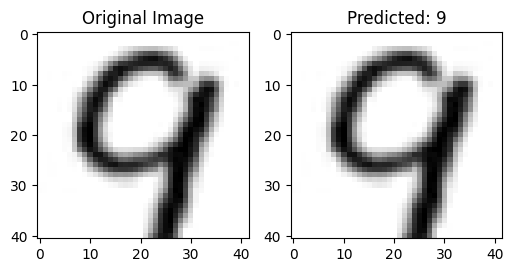

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


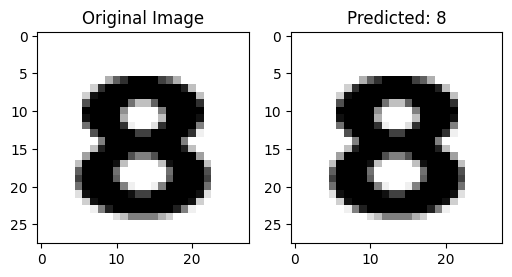

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


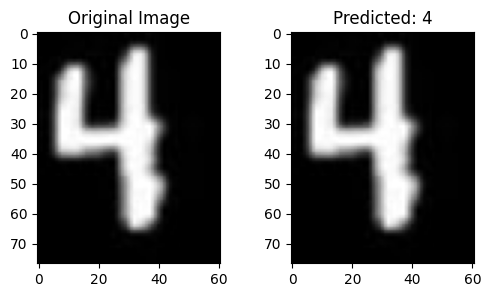

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


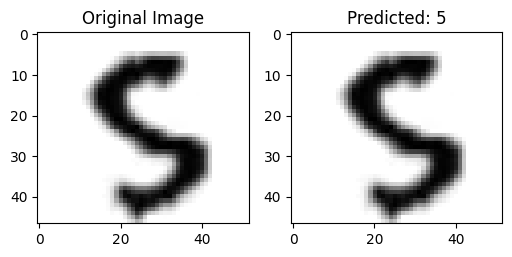

In [10]:
root = tk.Tk()
app = DigitRecognizerApp(root)
root.mainloop()